# Phase 1: Baseline Model Training (Optimized & Balanced)

This notebook implements the baseline training for the **OP-ECOM** project. It establishes a comparison between several traditional models on the UCI Online Shoppers Purchasing Intention dataset.

### Key Features:
1. **80/10/10 Split**: Training (80%), Testing (10%), and Validation (10%).
2. **Training Set Balancing**: Manual upsampling to ensure the AI learns from an equal number of buyers and non-buyers.
3. **Premium Visuals**: Lapis Lazuli themed performance charts.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_curve, precision_recall_curve
)
import xgboost as xgb
import joblib
import json
from datetime import datetime
from sklearn.utils import resample

# Premium Styling (لاجوردی)
plt.style.use('seaborn-v0_8-whitegrid')
PRIMARY_COLOR = '#1E4FA8'
SECONDARY_COLOR = '#E8F0FF'

# Paths
DATA_PATH = "../data/raw/online_shoppers_intention.csv"
MODELS_PATH = "../backend/models"
REPORTS_PATH = "../reports/metrics"

os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(REPORTS_PATH, exist_ok=True)

print("✅ Environment Ready!")

✅ Environment Ready!


## 1. Data Loading & Distribution
We start by loading the UCI dataset and verifying the class imbalance.

Dataset shape: (12330, 18)


C:\Users\khair\AppData\Local\Temp\ipykernel_15988\1646409629.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Revenue', data=df, palette=[SECONDARY_COLOR, PRIMARY_COLOR])


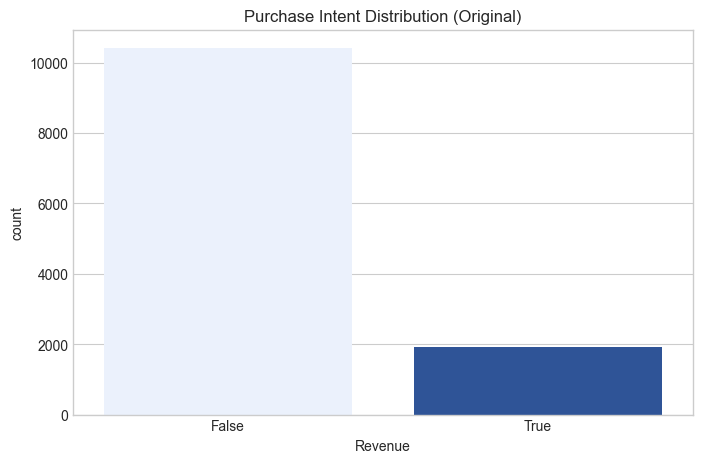

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [ ]:
df = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {df.shape}")

# Target distribution visualization
plt.figure(figsize=(8, 5))
sns.countplot(x='Revenue', data=df, palette=[SECONDARY_COLOR, PRIMARY_COLOR])
plt.title('Purchase Intent Distribution (Original)')
plt.show()

df.head()

In [ ]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [ ]:
df.tail(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False
12329,0,0.0,0,0.0,3,21.250000,0.000000,0.066667,0.000000,0.0,Nov,3,2,1,2,New_Visitor,True,False


## 2. Advanced Preprocessing
Implementing the 80/10/10 split and balancing the training set via upsampling.

In [ ]:
X = df.drop('Revenue', axis=1)
y = df['Revenue'].astype(int)

# 1. Features Handling
categorical_cols = ['Month', 'VisitorType', 'Weekend']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le



In [ ]:
# Mapping (The Dictionary)
for col, le in label_encoders.items():
    print(f"\n[Mapping] {col}:")
    for index, label in enumerate(le.classes_):
        print(f"  {index} -> {label}")


[Mapping] Month:
  0 -> Aug
  1 -> Dec
  2 -> Feb
  3 -> Jul
  4 -> June
  5 -> Mar
  6 -> May
  7 -> Nov
  8 -> Oct
  9 -> Sep

[Mapping] VisitorType:
  0 -> New_Visitor
  1 -> Other
  2 -> Returning_Visitor

[Mapping] Weekend:
  0 -> False
  1 -> True


In [ ]:
# 2. 80/10/10 Split Strategy
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Print the sizes of each bucket
print(f"📊 [Data Split Results]:")
print(f"   → Total Dataset Size: {len(X)}")
print(f"   → Training Set:       {len(X_train)} rows  (80%)")
print(f"   → Testing Set:        {len(X_test)} rows   (10%)")
print(f"   → Validation Set:     {len(X_val)} rows    (10%)")

# Confirm balancing (Stratification)
print(f"\n✅ [Class Balance Check]:")
print(f"   → % of Buyers in Train: {y_train.mean():.1%}")
print(f"   → % of Buyers in Test:  {y_test.mean():.1%}")
print(f"   → % of Buyers in Val:   {y_val.mean():.1%}")

📊 [Data Split Results]:
   → Total Dataset Size: 12330
   → Training Set:       9864 rows  (80%)
   → Testing Set:        1233 rows   (10%)
   → Validation Set:     1233 rows    (10%)

✅ [Class Balance Check]:
   → % of Buyers in Train: 15.5%
   → % of Buyers in Test:  15.5%
   → % of Buyers in Val:   15.5%


In [ ]:
# 3. Scaling
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_val_scaled = X_val.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])
X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])


In [ ]:
print("📉 [Scaling Verification - Means]:")
# We round to 5 decimal places because it might be a tiny scientific number like 0.00000001
print(X_train_scaled[numerical_cols].mean().round(5))



📉 [Scaling Verification - Means]:
Administrative            -0.0
Administrative_Duration   -0.0
Informational              0.0
Informational_Duration     0.0
ProductRelated             0.0
ProductRelated_Duration    0.0
BounceRates                0.0
ExitRates                  0.0
PageValues                -0.0
SpecialDay                -0.0
OperatingSystems           0.0
Browser                    0.0
Region                     0.0
TrafficType               -0.0
dtype: float64


In [ ]:
print("\n📊 [Scaling Verification - Std Dev]:")
print(X_train_scaled[numerical_cols].std().round(5))


📊 [Scaling Verification - Std Dev]:
Administrative             1.00005
Administrative_Duration    1.00005
Informational              1.00005
Informational_Duration     1.00005
ProductRelated             1.00005
ProductRelated_Duration    1.00005
BounceRates                1.00005
ExitRates                  1.00005
PageValues                 1.00005
SpecialDay                 1.00005
OperatingSystems           1.00005
Browser                    1.00005
Region                     1.00005
TrafficType                1.00005
dtype: float64


In [ ]:
print("\n🔍 [Row Comparison - Raw vs Scaled]:")
print(f"   Raw PageValues (Row 0):    {X_train['PageValues'].iloc[0]}")
print(f"   Scaled PageValues (Row 0): {X_train_scaled['PageValues'].iloc[0]:.4f}")


🔍 [Row Comparison - Raw vs Scaled]:
   Raw PageValues (Row 0):    12.27419487
   Scaled PageValues (Row 0): 0.3410


In [ ]:
# 4. Training Set Balancing (Oversampling)
train_data = pd.concat([X_train_scaled, y_train], axis=1)
not_buy = train_data[train_data.Revenue == 0]
buy = train_data[train_data.Revenue == 1]

buy_upsampled = resample(buy, replace=True, n_samples=len(not_buy), random_state=42)
train_balanced = pd.concat([not_buy, buy_upsampled])

X_train_final = train_balanced.drop('Revenue', axis=1)
y_train_final = train_balanced.Revenue

print(f"✅ Preprocessing Complete!")
print(f"   → Training: {len(X_train_final)} (Balanced)")
print(f"   → Test:     {len(X_test)}")
print(f"   → Val:      {len(X_val)}")

✅ Preprocessing Complete!
   → Training: 16676 (Balanced)
   → Test:     1233
   → Val:      1233


## 3. Multi-Model Training Pipeline
We train baseline models and collect metrics for a comprehensive comparison.

In [ ]:
# 3.1 Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_final, y_train_final)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
y_pred_lr = lr_model.predict(X_test_scaled)

# 3.2 XGBoost Classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_final, y_train_final)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 3.3 Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_final, y_train_final)
y_prob_dt = dt_model.predict_proba(X_test_scaled)[:, 1]
y_pred_dt = dt_model.predict(X_test_scaled)

# 3.4 Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train_final)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
y_pred_rf = rf_model.predict(X_test_scaled)

# 3.5 SVM (Support Vector Machine)
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_final, y_train_final)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]
y_pred_svm = svm_model.predict(X_test_scaled)

def get_metrics(name, y_true, y_pred, y_prob):
    return {
        'model': name,
        'auc_roc': roc_auc_score(y_true, y_prob),
        'f1': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred)
    }

results = [
    get_metrics('Logistic Regression', y_test, y_pred_lr, y_prob_lr),
    get_metrics('XGBoost', y_test, y_pred_xgb, y_prob_xgb),
    get_metrics('Decision Tree', y_test, y_pred_dt, y_prob_dt),
    get_metrics('Random Forest', y_test, y_pred_rf, y_prob_rf),
    get_metrics('SVM', y_test, y_pred_svm, y_prob_svm)
]

pd.DataFrame(results).set_index('model')

,auc_roc,f1,precision,recall
model,,,,
Logistic Regression,0.897197,0.645880,0.562016,0.759162
XGBoost,0.922004,0.685851,0.632743,0.748691
Decision Tree,0.749570,0.577428,0.578947,0.575916
Random Forest,0.930364,0.659740,0.654639,0.664921
SVM,0.908598,0.647702,0.556391,0.774869


## 4. Visual Comparison
Let's see the performance spread and feature importance across models.

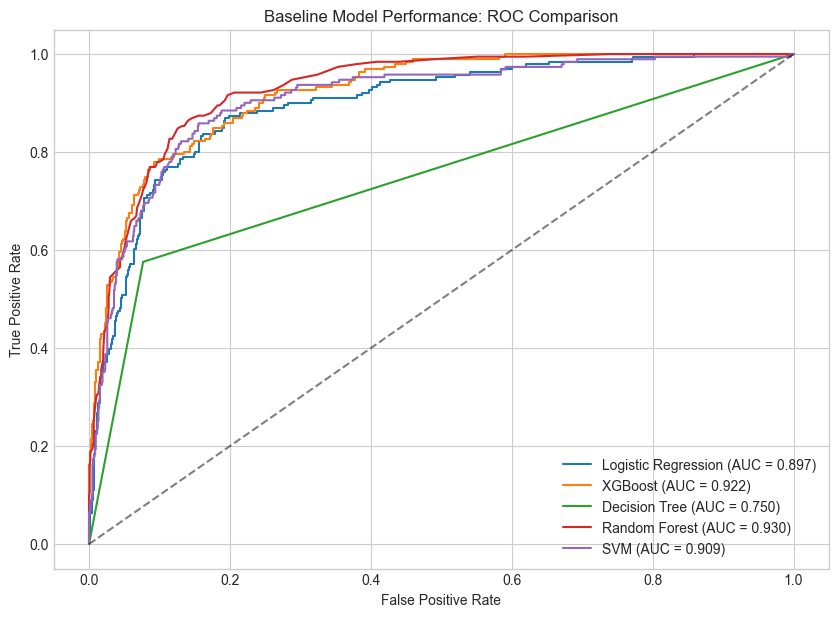

C:\Users\khair\AppData\Local\Temp\ipykernel_15988\3833032566.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_xgb.values, y=importance_xgb.index, ax=ax1, palette='Blues_r')
C:\Users\khair\AppData\Local\Temp\ipykernel_15988\3833032566.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_rf.values, y=importance_rf.index, ax=ax2, palette='Blues_r')


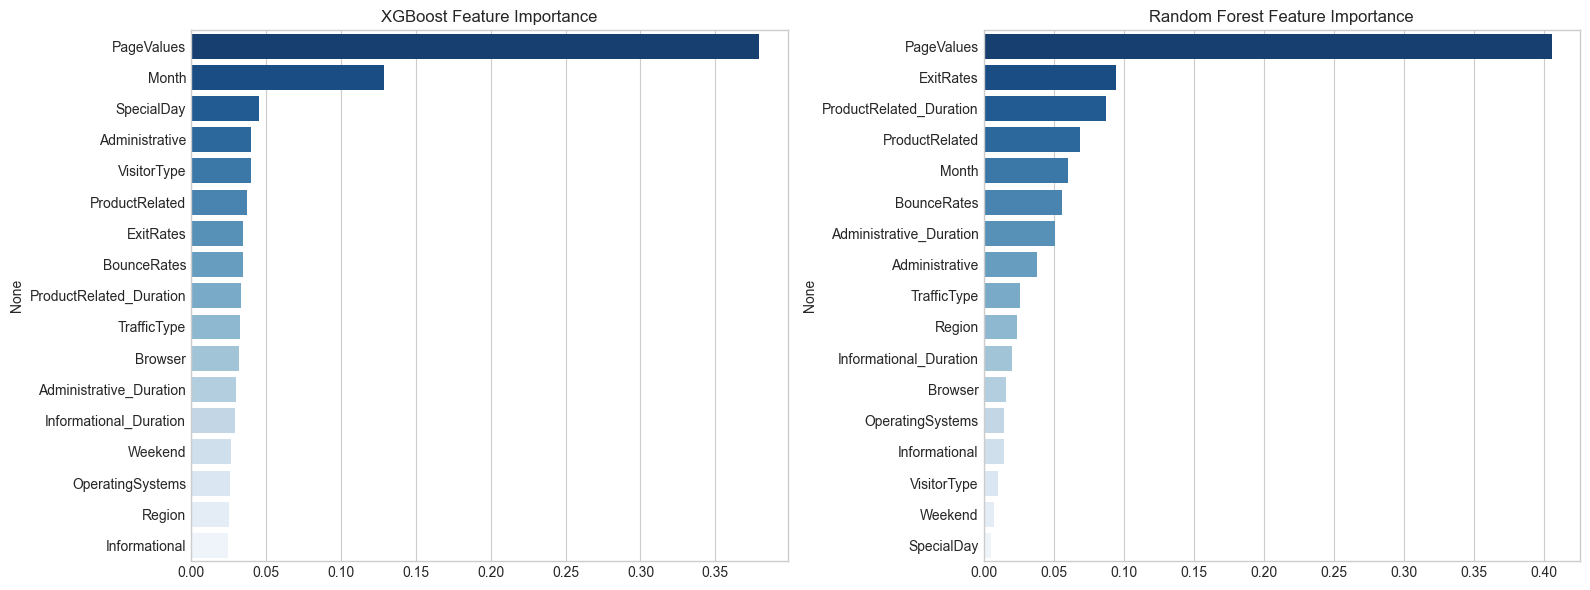

⭐ Best Baseline Model: Random Forest


['../backend/models/scaler.joblib']

In [ ]:
# 4.1 Combined ROC Curves
plt.figure(figsize=(10, 7))
probs = {
    'Logistic Regression': y_prob_lr,
    'XGBoost': y_prob_xgb,
    'Decision Tree': y_prob_dt,
    'Random Forest': y_prob_rf,
    'SVM': y_prob_svm
}

for name, prob in probs.items():
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline Model Performance: ROC Comparison')
plt.legend()
plt.show()

# 4.2 Feature Importance (Comparison)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

importance_xgb = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=importance_xgb.values, y=importance_xgb.index, ax=ax1, palette='Blues_r')
ax1.set_title('XGBoost Feature Importance')

importance_rf = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=importance_rf.values, y=importance_rf.index, ax=ax2, palette='Blues_r')
ax2.set_title('Random Forest Feature Importance')

plt.tight_layout()
plt.show()

# 5. Saving Results
best_result = pd.DataFrame(results).set_index('model')['auc_roc'].idxmax()
print(f"⭐ Best Baseline Model: {best_result}")

# Save metrics
with open(f"{REPORTS_PATH}/baseline_comparison.json", "w") as f:
    json.dump(results, f, indent=4)

# Save core components
joblib.dump(xgb_model, f"{MODELS_PATH}/xgb_baseline.joblib")
joblib.dump(rf_model, f"{MODELS_PATH}/rf_baseline.joblib")
joblib.dump(lr_model, f"{MODELS_PATH}/lr_baseline.joblib")
joblib.dump(scaler, f"{MODELS_PATH}/scaler.joblib")